## Seattle Bird Call Classification Using Neural Networks

## Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions, preprocess_input
from keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications.mobilenet import preprocess_input

## Loading the dataset

In [2]:
# h5 file of Bird species data
species_data = h5py.File('spectrograms.h5', 'r')

# Keys for different species
species_keys = list(species_data.keys())

species_keys

['amecro',
 'barswa',
 'bkcchi',
 'blujay',
 'daejun',
 'houfin',
 'mallar3',
 'norfli',
 'rewbla',
 'stejay',
 'wesmea',
 'whcspa']

In [3]:
# Shape of the spectogram data 
# Here, we selected one species out of 12 to see the shape
dset = species_data['stejay']

dset.shape

(256, 343, 40)

## Binary Classification Model

We will use Northern Flicker and Steller's Jay bird species for this model

In [4]:
# Load data for the selected species
# norfli sound for Northern Flicker data and stejay for Steller's Jay data
norfli_data = species_data['norfli'][:] 
stejay_data = species_data['stejay'][:]  

In [5]:
norfli_data.shape

(256, 343, 59)

In [6]:
# Now Let's label the selected species
# Using 0 for Northern Flicker birds and 1 for Steller's Jay birds
norfli_data_labels = np.zeros(norfli_data.shape[2])
stejay_data_labels = np.ones(stejay_data.shape[2])

In [7]:
# After the above step, combining the data and labels
X_bin = np.concatenate((norfli_data, stejay_data), axis=2)
y_bin = np.concatenate((norfli_data_labels, stejay_data_labels), axis=0)

In [8]:
# Normalizing the data
X_bin = X_bin / np.max(X_bin)

# Reshaping X to match the expected input shape for CNNs (frequency, timesteps, no. of samples)
X_bin = np.transpose(X_bin, (2, 0, 1))
X_bin = X_bin[..., np.newaxis]  # This will add a channel dimension 

In [9]:
# Now, Converting the labels to categorical data
y_bin = to_categorical(y_bin, 2)

In [10]:
# Splitting the data into training and validation sets (70% training set and 30% validation set)
X_train, X_val, y_train, y_val = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42)

In [11]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(69, 256, 343, 1) (30, 256, 343, 1) (69, 2) (30, 2)


In [12]:
# Defining the CNN model for our Binary classification 
Bin_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 343, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

C:\Users\hirshikesh\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Model summary
Bin_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 341, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 170, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 170, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 168, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 84, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 84, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 333312)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      42,664,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,683,138 (162.82 MB)

 Trainable params: 42,683,138 (162.82 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compiling the model
Bin_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Training the model
history = Bin_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step - accuracy: 0.6542 - loss: 0.6896 - val_accuracy: 0.7333 - val_loss: 0.6206
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - accuracy: 0.7423 - loss: 0.5978 - val_accuracy: 0.9667 - val_loss: 0.4982
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - accuracy: 0.9130 - loss: 0.3986 - val_accuracy: 0.9333 - val_loss: 0.3064
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.9186 - loss: 0.2556 - val_accuracy: 0.9667 - val_loss: 0.2011
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 0.9431 - loss: 0.2363 - val_accuracy: 0.9333 - val_loss: 0.1925
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.9364 - loss: 0.1697 - val_accuracy: 0.9667 - val_loss: 0.1470
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step - accuracy: 0.9398 - loss: 0.1364 - val_accuracy: 0.9667 - val_loss: 0.1089
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - accuracy: 0.9810 - loss: 0.0622 - val_accuracy: 0.9667 - val_loss:

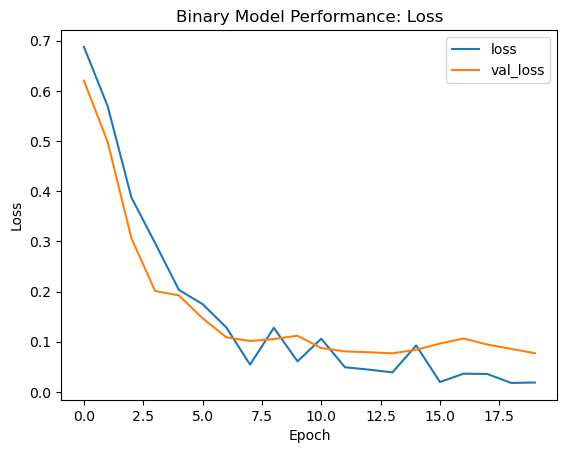

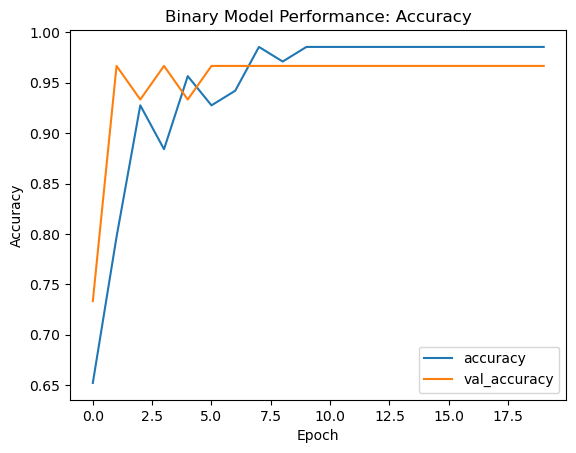

In [16]:
# Model Performance Plot 
# Loss performance
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Model Performance: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show();

# Accuracy performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Binary Model Performance: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

In [17]:
# Evaluating the model on the validation set
val_loss, val_accuracy = Bin_model.evaluate(X_val, y_val)

# Result
print(f'Validation Loss for Binary Model: {val_loss}')
print(f'Validation Accuracy for Binary Model: {val_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9667 - loss: 0.0772
Validation Loss for Binary Model: 0.07719671726226807
Validation Accuracy for Binary Model: 0.9666666388511658


In [18]:
# Predicting new data
predictions = Bin_model.predict(X_val)

# Converting probabilities to class labels
predicted_classes = (predictions > 0.5).astype(int)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


In [19]:
# Now, converting labels to integer labels
true_classes = np.argmax(y_val, axis=1)
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=['Northern Flicker', 'Steller’s Jay'])
print(report)

                  precision    recall  f1-score   support

Northern Flicker       0.95      1.00      0.97        18
   Steller’s Jay       1.00      0.92      0.96        12

        accuracy                           0.97        30
       macro avg       0.97      0.96      0.96        30
    weighted avg       0.97      0.97      0.97        30



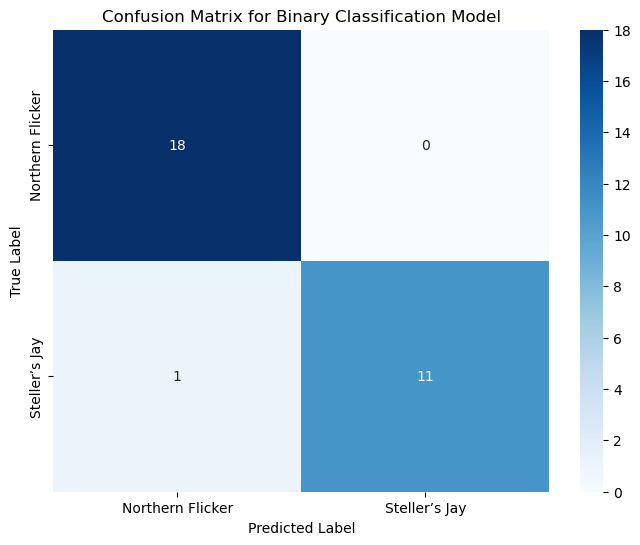

In [20]:
# Confusion Matrix 
matrix = confusion_matrix(true_classes, predicted_classes)

# Heatmap For confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Northern Flicker', 'Steller’s Jay'],
            yticklabels=['Northern Flicker', 'Steller’s Jay'])
plt.title('Confusion Matrix for Binary Classification Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Multi-Class Classification Model for all 12 Bird Species

In [21]:
# Load data for all species and their labels
# We created a empty lists for data and their labels 
# X_multi : data samples for all bird species 
# y_multi : labels for all birds species
X_multi = []
y_multi = []

# Now, looping over each species key to load the for all species data
for index, key in enumerate(species_keys):
    data = species_data[key][:]
    # We created a label array to fill the species index
    labels = np.full(data.shape[2], index)  
    X_multi.append(data)
    y_multi.append(labels)

In [22]:
# Now, combining the data and labels from all species 
X_multi = np.concatenate(X_multi, axis=2)
y_multi = np.concatenate(y_multi, axis=0)

In [23]:
# Normalizing the data
X_multi = X_multi / np.max(X_multi)

In [24]:
# Reshaping X to match the expected input shape for CNNs (frequency, timesteps, samples)
X_multi = np.transpose(X_multi, (2, 0, 1))
X_multi = X_multi[..., np.newaxis]  # this will adds a channel dimension

In [25]:
# Converting the labels to categorical data
y_multi = to_categorical(y_multi, len(species_keys))

In [26]:
# Splitting the data into training and validation sets (70% training set and 30% validation set)
X_train, X_val, y_train, y_val = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

In [27]:
# Defining the CNN model for Multi-class classification
Multi_class_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 343, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [28]:
# Model summary
Multi_class_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 254, 341, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 170, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 168, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 84, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 333312)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      85,328,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,350,028 (325.58 MB)

 Trainable params: 85,350,028 (325.58 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compiling the model
Multi_class_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Training the model
history = Multi_class_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.2160 - loss: 2.3056 - val_accuracy: 0.3908 - val_loss: 1.8335
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5690 - loss: 1.4658 - val_accuracy: 0.5632 - val_loss: 1.4413
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7315 - loss: 0.9518 - val_accuracy: 0.6207 - val_loss: 1.2854
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8107 - loss: 0.7061 - val_accuracy: 0.5862 - val_loss: 1.2784
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8374 - loss: 0.5553 - val_accuracy: 0.5690 - val_loss: 1.3036
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8760 - loss: 0.4586 - val_accuracy: 0.6379 - val_loss: 1.2529
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8879 - loss: 0.3946 - val_accuracy: 0.6379 - val_loss: 1.2448
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9017 - loss: 0.2709 - val_accuracy: 0.6494 - val_loss: 1.2986
Epoch 9/20
4/4 

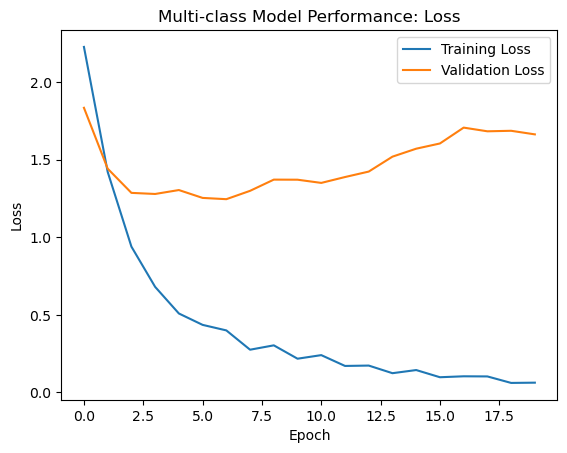

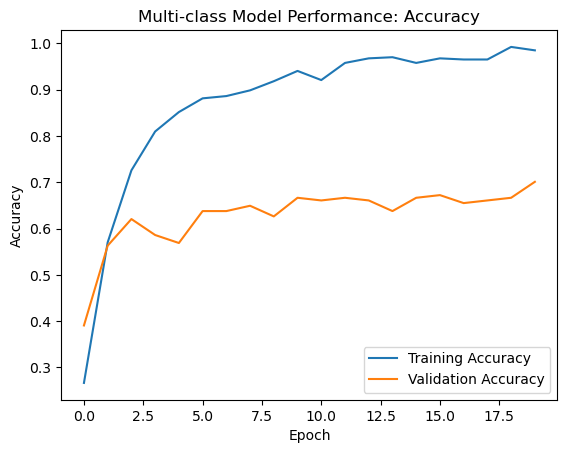

In [31]:
# Model Performance Plot for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multi-class Model Performance: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Model Performance Plot for Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Multi-class Model Performance: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [32]:
# Evaluating the model on the validation set
val_loss, val_accuracy = Multi_class_model.evaluate(X_val, y_val)

# Result
print(f'Validation Loss for Multi-class Model: {val_loss}')
print(f'Validation Accuracy for Multi-class Model: {val_accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6834 - loss: 1.6372
Validation Loss for Multi-class Model: 1.6622616052627563
Validation Accuracy for Multi-class Model: 0.7011494040489197


In [33]:
# Predicting new data
predictions = Multi_class_model.predict(X_val)

# Converting probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


In [34]:
# Now, converting labels to integer labels
true_classes = np.argmax(y_val, axis=1)

# Classification report for multi-class model
report = classification_report(true_classes, predicted_classes, target_names = species_keys)
print(report)

              precision    recall  f1-score   support

      amecro       0.93      0.93      0.93        14
      barswa       0.73      0.33      0.46        24
      bkcchi       0.62      0.94      0.74        17
      blujay       0.60      0.50      0.55        18
      daejun       0.94      0.94      0.94        17
      houfin       0.57      0.80      0.67        10
     mallar3       0.75      0.90      0.82        10
      norfli       0.53      0.75      0.62        12
      rewbla       0.67      0.46      0.55        13
      stejay       0.50      0.60      0.55        10
      wesmea       0.89      0.67      0.76        12
      whcspa       0.78      0.82      0.80        17

    accuracy                           0.70       174
   macro avg       0.71      0.72      0.70       174
weighted avg       0.72      0.70      0.69       174



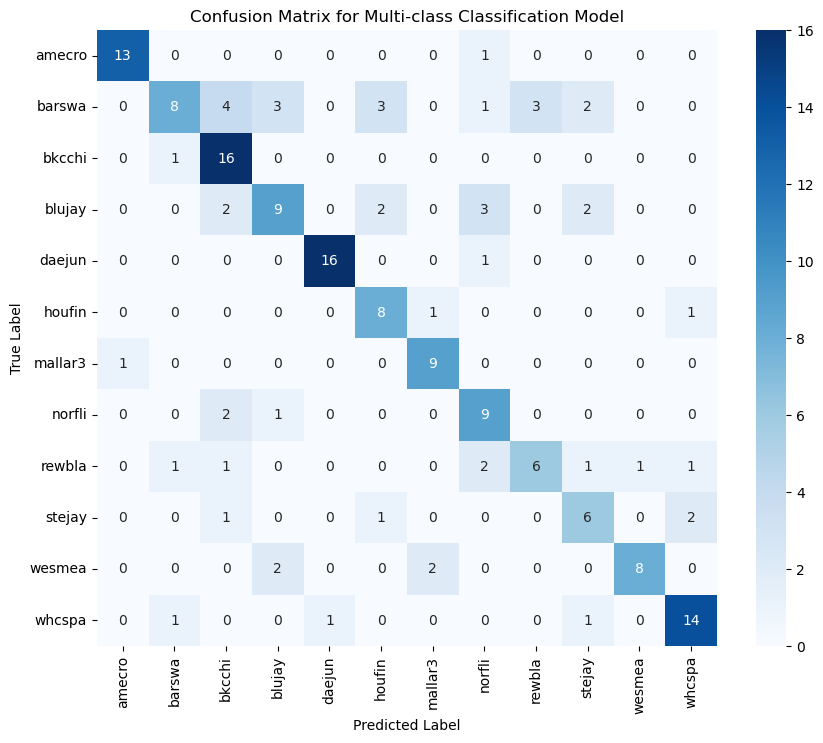

In [35]:
# Confusion Matrix for multi-class model
matrix = confusion_matrix(true_classes, predicted_classes)

# Heatmap For confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=species_keys,
            yticklabels=species_keys)
plt.title('Confusion Matrix for Multi-class Classification Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [36]:
# Defining the 2nd CNN model for Multi-class classification
Multi_class_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 343, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [37]:
# Model summary
Multi_class_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 341, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 170, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 168, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 84, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 82, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 39, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 19, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 68096)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      17,432,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,823,756 (67.99 MB)

 Trainable params: 17,823,756 (67.99 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compiling the model
Multi_class_model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Training the model
history2 = Multi_class_model2.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2316 - loss: 2.2958 - val_accuracy: 0.4770 - val_loss: 1.7246
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5040 - loss: 1.6057 - val_accuracy: 0.4943 - val_loss: 1.4462
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5891 - loss: 1.1873 - val_accuracy: 0.5632 - val_loss: 1.3274
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7353 - loss: 0.8904 - val_accuracy: 0.5862 - val_loss: 1.2149
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7833 - loss: 0.6365 - val_accuracy: 0.6207 - val_loss: 1.2232
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8751 - loss: 0.4586 - val_accuracy: 0.6552 - val_loss: 1.2980
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8914 - loss: 0.3801 - val_accuracy: 0.6782 - val_loss: 1.3552
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8949 - loss: 0.3602 - val_accuracy: 0.6322 - val_loss: 1.5987
Epoch 9/

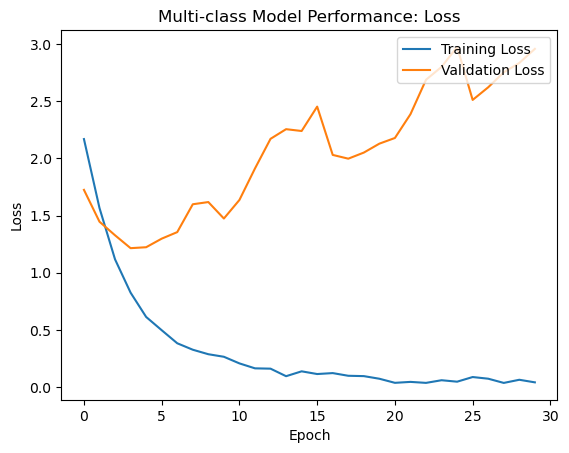

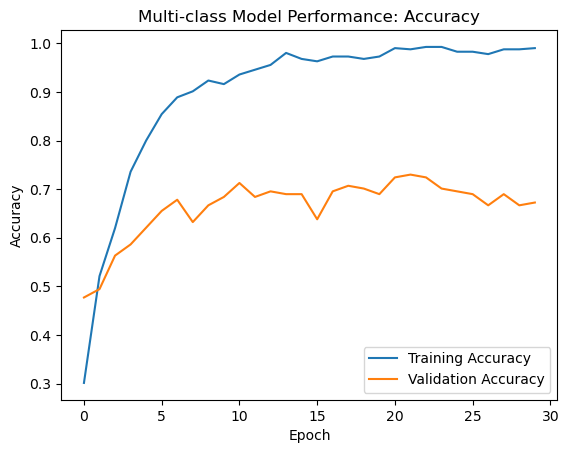

In [40]:
# Model Performance Plot for Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Multi-class Model Performance: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Model Performance Plot for Accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Multi-class Model Performance: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [41]:
# Evaluating the model on the validation set
val_loss2, val_accuracy2 = Multi_class_model2.evaluate(X_val, y_val)

# Result
print(f'Validation Loss for Multi-class Model2: {val_loss2}')
print(f'Validation Accuracy for Multi-class Model2: {val_accuracy2}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6759 - loss: 3.1402
Validation Loss for Multi-class Model2: 2.9570038318634033
Validation Accuracy for Multi-class Model2: 0.6724137663841248


In [42]:
# Predicting new data
predictions2 = Multi_class_model2.predict(X_val)

# Converting probabilities to class labels
predicted_classes2 = np.argmax(predictions2, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


In [43]:
# Now, converting labels to integer labels
true_classes2 = np.argmax(y_val, axis=1)

# Classification report for multi-class model
report2 = classification_report(true_classes2, predicted_classes2, target_names = species_keys)
print(report)

              precision    recall  f1-score   support

      amecro       0.93      0.93      0.93        14
      barswa       0.73      0.33      0.46        24
      bkcchi       0.62      0.94      0.74        17
      blujay       0.60      0.50      0.55        18
      daejun       0.94      0.94      0.94        17
      houfin       0.57      0.80      0.67        10
     mallar3       0.75      0.90      0.82        10
      norfli       0.53      0.75      0.62        12
      rewbla       0.67      0.46      0.55        13
      stejay       0.50      0.60      0.55        10
      wesmea       0.89      0.67      0.76        12
      whcspa       0.78      0.82      0.80        17

    accuracy                           0.70       174
   macro avg       0.71      0.72      0.70       174
weighted avg       0.72      0.70      0.69       174



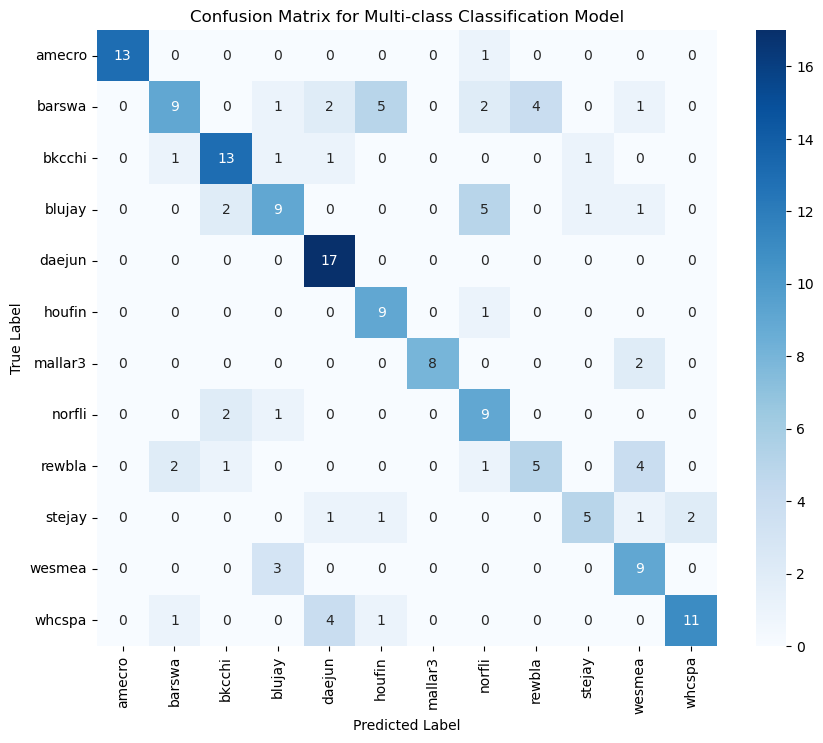

In [44]:
# Confusion Matrix for multi-class model
matrix2 = confusion_matrix(true_classes2, predicted_classes2)

# Heatmap For confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix2, annot=True, fmt="d", cmap="Blues",
            xticklabels=species_keys,
            yticklabels=species_keys)
plt.title('Confusion Matrix for Multi-class Classification Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

 ## Multi-Class Model on External Test Data

In [52]:
# Function to preprocess the test audio files and generate spectrograms for the same
def preprocess_test_clips(clip_path):
    y, sr = librosa.load(clip_path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=22050)
    intervals = librosa.effects.split(y, top_db=20)
    clips = [y[start:end] for start, end in intervals if (end - start) > 0.5 * sr]
    
    spectrograms = []
    for clip in clips:
        if len(clip) > 2 * sr:
            for i in range(0, len(clip) - 2 * sr, 2 * sr):
                window = clip[i:i + 2 * sr]
                S = librosa.feature.melspectrogram(y=window, sr=22050, n_mels=256, fmax=8000)
                S_dB = librosa.power_to_db(S, ref=np.max)
                S_dB_resized = resize(S_dB, (256, 343))  # Resize to match input shape of the model
                spectrograms.append(S_dB_resized)
        else:
            window = librosa.util.fix_length(clip, 2 * sr)
            S = librosa.feature.melspectrogram(y=window, sr=22050, n_mels=256, fmax=8000)
            S_dB = librosa.power_to_db(S, ref=np.max)
            S_dB_resized = resize(S_dB, (256, 343))  # Resize to match input shape of the model
            spectrograms.append(S_dB_resized)
    
    return spectrograms

In [53]:
# Function to predict bird species from the test spectrograms
def predict(spectrograms, model, species_keys):
    predictions = []
    for spectrogram in spectrograms:
        spectrogram = np.expand_dims(spectrogram, axis=0)  # Adding the  batch dimension
        spectrogram = np.expand_dims(spectrogram, axis=-1)  # This is to add channel dimension if grayscale is present
        prediction = model.predict(spectrogram)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predictions.append((species_keys[predicted_class], prediction[0]))
    return predictions

In [54]:
# Function to analyze predictions and format output
def analyze_preds(predictions, species_keys):
    detailed_predictions = []
    for species, probs in predictions:
        sorted_probs = sorted(zip(species_keys, probs), key=lambda x: x[1], reverse=True)
        top_preds = sorted_probs[:3]
        detailed_predictions.append(top_preds)
    return detailed_predictions

In [55]:
# Load the trained model
model = Multi_class_model2

# Directory containing the test clips
test_clips = 'test_birds/'

# Processing each test file and storing the results
test_files = [os.path.join(test_clips, f) for f in os.listdir(test_clips) if f.endswith('.mp3')]
results = []

for test_file in test_files:
    spectrograms = preprocess_test_clips(test_file)
    predictions = predict(spectrograms, model, species_keys)
    detailed_predictions = analyze_preds(predictions, species_keys)
    
    results.append({
        'File': test_file,
        'Predictions': detailed_predictions
    })

# Displaying results in a table
results_df = pd.DataFrame(results)
print(results_df)
print("\n")

# Checking the presence of multiple bird calls in each clip
for index, row in results_df.iterrows():
    multiple_bird_call = False
    for prediction in row['Predictions']:
        if len(prediction) > 1 and prediction[1][1] > 0.5:
            multiple_bird_call = True
            break
    if multiple_bird_call:
        print(f"{row['File']} may contain more than one bird call.")
    else:
        print(f"{row['File']} is likely to contain single bird call.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
                   File                                        Predictions
0  test_birds/test1.mp3  [[(daejun, 1.0), (amecro, 0.0), (barswa, 0.0)]...
1  test_birds/test2.mp3    [[(daejun, 1.0), (amecro, 0.0), (barswa, 0.0)]]
2  test_birds/test3.mp3  [[(daejun, 1.0), (amecro, 0.0), (barswa, 0.0)]...


test_birds/test1.mp3 is likely to contain single bird call.
test_birds/test2.mp3 is likely to contain single bird call.
test_birds/test3.mp3 is likely to contain single bird call.


## References
- 1) Lecture Notes

- 2) Ch10-1 and Ch10-2 Kereas files from the lecture materials

- 3) Keras and Tensorflow documentation: 
   https://www.tensorflow.org/guide
   
- 4) Audio Classification model of CNN for constructing spectograms: 
   https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb
   
- 5) Librosa documentation: https://librosa.org/doc/latest/index.html

- 6) Librosa API reference: https://librosa.org/doc/latest/api.html